In [1]:
!pip install tf-nightly

You should consider upgrading via the 'c:\users\kmj\pycharmprojects\pythonproject\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
from glob import glob

In [3]:
path = "./kfood"
for path, dirs, files in os.walk(path):
    for i in files:
        if i.endswith(".jpg"):
            pass
        else:
            os.remove(os.path.join(path,i))

In [4]:
image_count = len(list(glob('./kfood/*/*.jpg')))
print(image_count)

2961


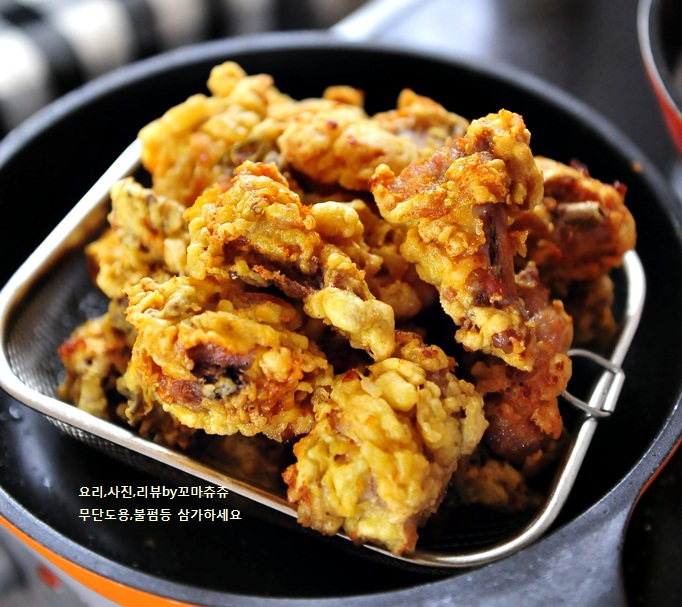

In [6]:
fish = list(glob('./kfood/후라이드치킨/*'))
PIL.Image.open(str(fish[1]))

In [7]:
batch_size = 30
img_height = 180
img_width = 180

In [8]:
path = "./kfood"
data_dir = str(path)

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2961 files belonging to 3 classes.
Using 2369 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2961 files belonging to 3 classes.
Using 592 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['불고기', '전복죽', '후라이드치킨']
3


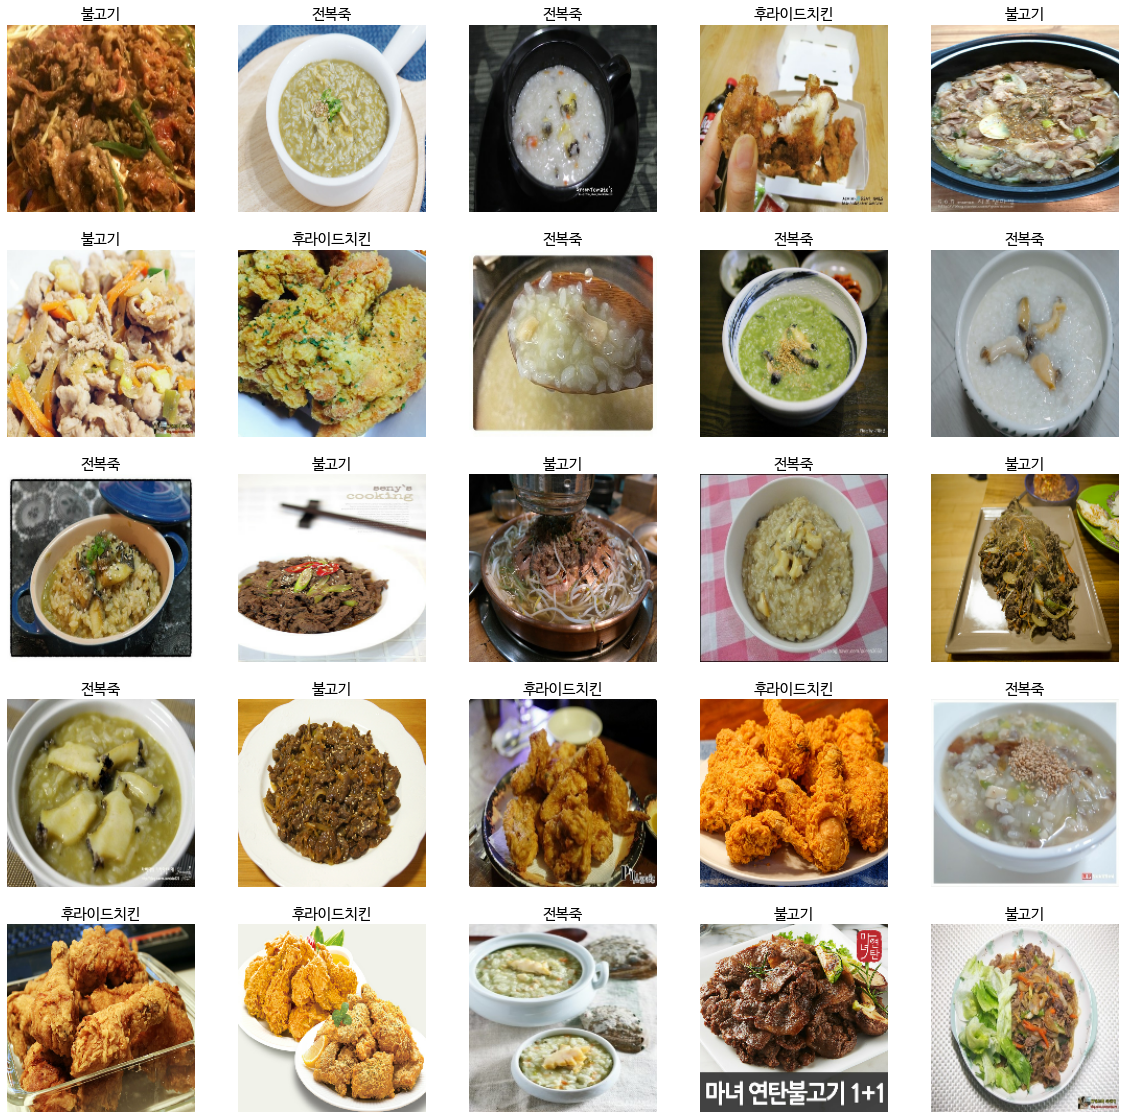

In [12]:
import matplotlib.font_manager as fm

path = "./NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=path, size=15)

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]], fontproperties=fontprop)
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(30, 180, 180, 3)
(30,)


In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[15]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [17]:
num_classes = 150

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [20]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
79/79 [==============================] - 20s 250ms/step - loss: 0.8359 - accuracy: 0.6745 - val_loss: 0.4035 - val_accuracy: 0.8378
Epoch 2/5
79/79 [==============================] - 19s 238ms/step - loss: 0.4206 - accuracy: 0.8379 - val_loss: 0.3230 - val_accuracy: 0.8649
Epoch 3/5
79/79 [==============================] - 19s 242ms/step - loss: 0.2781 - accuracy: 0.9012 - val_loss: 0.2939 - val_accuracy: 0.8818
Epoch 4/5
79/79 [==============================] - 20s 248ms/step - loss: 0.1975 - accuracy: 0.9341 - val_loss: 0.3455 - val_accuracy: 0.8767
Epoch 5/5
79/79 [==============================] - 19s 243ms/step - loss: 0.1398 - accuracy: 0.9489 - val_loss: 0.3444 - val_accuracy: 0.8699


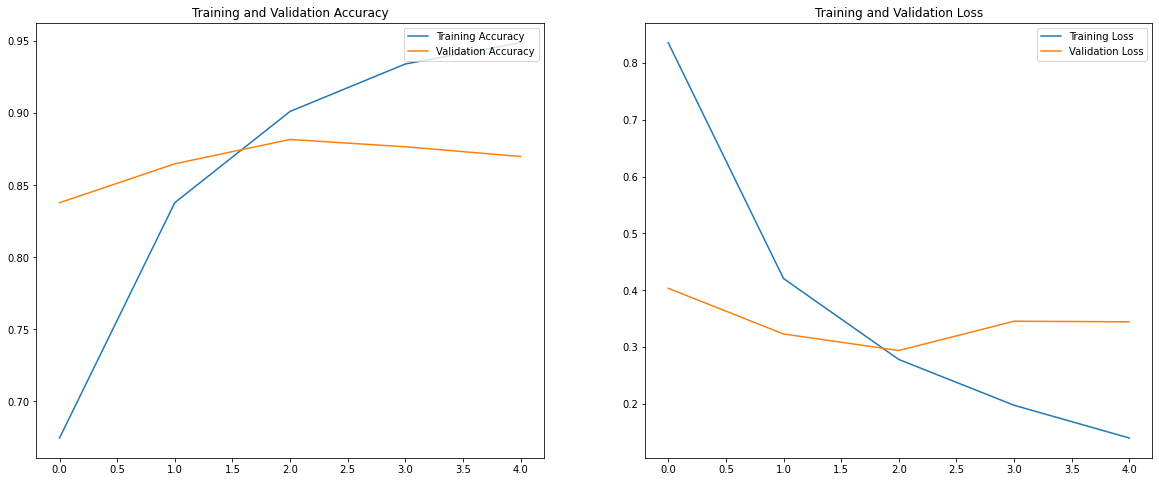

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

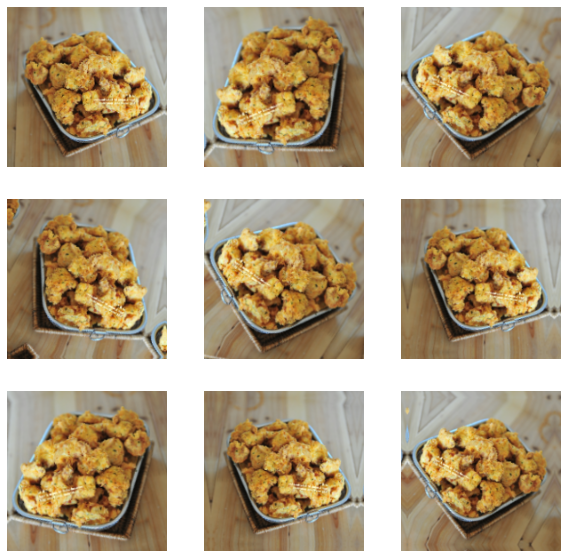

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [24]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [27]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
79/79 [==============================] - 23s 282ms/step - loss: 1.0177 - accuracy: 0.5737 - val_loss: 1.1292 - val_accuracy: 0.5591
Epoch 2/15
79/79 [==============================] - 22s 284ms/step - loss: 0.4879 - accuracy: 0.8092 - val_loss: 0.4838 - val_accuracy: 0.8159
Epoch 3/15
79/79 [==============================] - 23s 290ms/step - loss: 0.3761 - accuracy: 0.8573 - val_loss: 0.5201 - val_accuracy: 0.8091
Epoch 4/15
79/79 [==============================] - 23s 285ms/step - loss: 0.3371 - accuracy: 0.8683 - val_loss: 0.3871 - val_accuracy: 0.8378
Epoch 5/15
79/79 [==============================] - 23s 287ms/step - loss: 0.3089 - accuracy: 0.8801 - val_loss: 0.3499 - val_accuracy: 0.8649
Epoch 6/15
79/79 [==============================] - 23s 292ms/step - loss: 0.2864 - accuracy: 0.8953 - val_loss: 1.0066 - val_accuracy: 0.7010
Epoch 7/15
79/79 [==============================] - 23s 292ms/step - loss: 0.2756 - accuracy: 0.8966 - val_loss: 0.5797 - val_accuracy: 0.8007

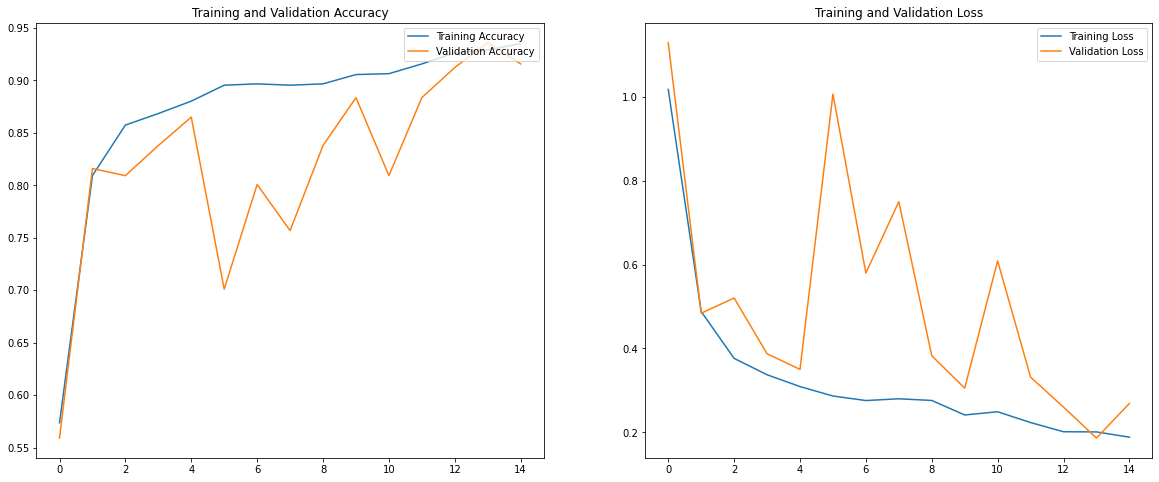

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
# new_url = "https://recipe1.ezmember.co.kr/cache/recipe/2018/02/10/a9e93c1f2dc682239fc7e156c121fb6a1.jpg"
# path = "./kft/test_image.jpg"
# import urllib.request as req
# req.urlretrieve(new_url, path)

path = "./Img_test_chicken.jpg"

img = keras.preprocessing.image.load_img(
    path, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "예측값: {}(정확도 {:.2f}%)"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

예측값: 후라이드치킨(정확도 99.75%)


In [30]:
from tensorflow.keras.models import load_model
from tensorflow import keras 

model.save("kf_model.h5")
model = keras.models.load_model('./kf_model.h5')
path = "./Img_test_chicken.jpg"

img = keras.preprocessing.image.load_img(
    path, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "예측값: {}(정확도 {:.2f}%)"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

예측값: 후라이드치킨(정확도 99.75%)
